# Frequency scaling

author: laquitainesteeve@gmail.com

Validation of frequency scaling.

Execution time: 10 secs

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz)

Resources required: 
- 180 GB RAM

## Setup

Prerequisites:

1. Setup "_envs/spikebias.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name spikebias --display-name "spikebias"_
3. Download recordings: "_notebooks/0_download_recordings.ipynb_"
4. Pre-compute power spectral densities with: "_src/pipes/validation/psd/multiprocess.py_"

    


In [ ]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

# import custom package
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000        # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000        # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# setup recordings paths
RAW_PATH_ns = "dataset/00_raw/recording_npx_spont"
RAW_PATH_ne = "dataset/00_raw/recording_npx_evoked"
RAW_PATH_nb = "dataset/00_raw/recording_buccino_rep"
RAW_PATH_ms = "dataset/00_raw/recording_marques_smith"

# setup power spectral densities paths
PRE_PSD_PATH_MS = "dataset/01_intermediate/psds/psd_prep_marques_smith_cutoff_100.npy"
PRE_PSD_PATH_NS = "dataset/01_intermediate/psds/psd_prep_npx_spont_cutoff_100.npy"
PRE_PSD_PATH_NE = "dataset/01_intermediate/psds/psd_prep_npx_evoked_cutoff_100.npy"
PRE_PSD_PATH_NB = "dataset/01_intermediate/psds/psd_prep_buccino_cutoff_100.npy"

# pipeline parameters
SAVE_FIG = True
SAVE_TEMP_DATA = True
LOAD_TEMP_DATA = False
PLOT_DATA_PATH = "dataset/02_figure_dataset/fig2s_data_fscaling_npx.parquet"

# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)

# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame


# parameterize
FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

### Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 32
available gpus: True


['               total        used        free      shared  buff/cache   available',
 'Mem:          192987       32617       90117         307       72230      160370',
 'Swap:           8191        7419         772']

### Custom functions

In [4]:
def print_slope(alpha):
    print(f"\u03B1={np.round(np.mean(alpha),1)}\u00B1{np.round(np.std(alpha),1)}")


def get_slope_df(data: list, exp, layer):
    df = pd.DataFrame()
    df["Alpha"] = np.negative(data)
    df["Experiment"] = exp
    df["Layer"] = layer
    return df

### (1s)Load dataset

* select first 10 min for speed

In [5]:
# Load traces
RawMS = si.load_extractor(RAW_PATH_ms)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
RawNB = si.load_extractor(RAW_PATH_nb)

# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# spontaneous
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# marques-smith
site_ly_nv = RawMS.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# Load pre-computed PSDs
psd_pre_ms = np.load(PRE_PSD_PATH_MS, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()

# unit-test power spectral density resolutions
assert psd_pre_ms["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

# All Layers


LFP band
α=0.1±0.1
α=0.4±0.1
α=0.4±0.2

Spiking band
α=-0.7±0.3
α=-0.4±0.3
α=-0.4±0.3


n=226 sites
n=202 sites
n=202 sites

Power SNR
SNR: 41.65746307373047
SNR: 10.001850128173828
SNR: 3.4196879863739014
SNR: 10.518378257751465


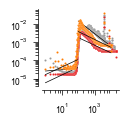

In [6]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Fit panel ************************************************************

ax1, alphas_lfp_ms, alphas_spiking_ms = power.plot_fits_all(
    ax1, psd_pre_ms, prm["SFREQ_NV"], cl["COLOR_NV"], pm, pm_fit1, pm_fit2, lfp_band=(0, 90), spiking_band=(100, 10000)
)
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_pre_ns, prm["SFREQ_NS"], cl["COLOR_NS"], pm, pm_fit1, pm_fit2, lfp_band=(0, 90), spiking_band=(100, 10000)
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_pre_ne, prm["SFREQ_NE"], cl["COLOR_NE"], pm, pm_fit1, pm_fit2, lfp_band=(0, 90), spiking_band=(100, 10000)
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))

# report slopes
# lfp band
print("\nLFP band")
print_slope(alphas_lfp_ms)
print_slope(alphas_lfp_ns)
print_slope(alphas_lfp_ne)

# spiking band
print("\nSpiking band")
print_slope(alphas_spiking_ms)
print_slope(alphas_spiking_ns)
print_slope(alphas_spiking_ne)

# print sites
print("\n")
print(f"""n={psd_pre_ms["power"].shape[0]} sites""")
print(f"""n={psd_pre_ns["power"].shape[0]} sites""")
print(f"""n={psd_pre_ne["power"].shape[0]} sites""")


# SNR **************************
print("\nPower SNR")

out_nv = power.get_power_snr(psd_pre_ms["power"], psd_pre_ms["freq"], 100, 10000, 90)
out_ns = power.get_power_snr(psd_pre_ns["power"], psd_pre_ns["freq"], 100, 10000, 90)
out_ne = power.get_power_snr(psd_pre_ne["power"], psd_pre_ne["freq"], 100, 10000, 90)
out_nb = power.get_power_snr(psd_pre_nb["power"], psd_pre_nb["freq"], 100, 10000, 90)

## Compute layer-wise data 

In [7]:
d1 = power.get_psd_data_prepro_npx(
    "L1",
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d23 = power.get_psd_data_prepro_npx(
    "L2_3",
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d4 = power.get_psd_data_prepro_npx(
    "L4",
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)
d5 = power.get_psd_data_prepro_npx_layer_5(
    "L5",
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    psd_pre_nb,
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d6 = power.get_psd_data_prepro_npx(
    "L6",
    psd_pre_ms,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

## Power law fits



LFP band
nv: α=0.1±0.1
ns: α=0.3±0.0
ne: α=0.2±0.0

Spiking band
nv: α=-0.6±0.1
ns: α=-0.3±0.0
ne: α=-0.2±0.0

LFP band
nv: α=0.0±0.1
ns: α=0.4±0.0
ne: α=0.3±0.2

Spiking band
nv: α=-0.5±0.1
ns: α=-0.2±0.0
ne: α=-0.2±0.1

LFP band
nv: α=0.0±0.1
ns: α=0.5±0.0
ne: α=0.5±0.1

Spiking band
nv: α=-0.4±0.1
ns: α=-0.6±0.1
ne: α=-0.6±0.1

LFP band
α=0.1±0.1
α=0.6±0.1
α=0.6±0.2
α=0.4±0.3

Spiking band
α=-0.7±0.2
α=-0.8±0.1
α=-0.8±0.2
α=-0.5±0.5

Power SNR
SNR: 45.80379104614258
SNR: 8.467751502990723
SNR: 2.9833710193634033
SNR: 11.646443367004395

LFP band
nv: α=0.1±0.1
ns: α=0.3±0.0
ne: α=0.3±0.2

Spiking band
nv: α=-0.9±0.4
ns: α=-0.3±0.1
ne: α=-0.3±0.2


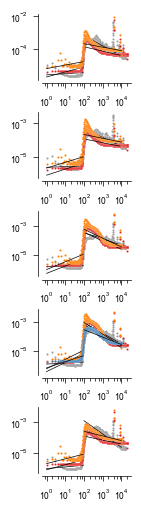

In [8]:
# cutoff 100 Hz
FIG_SIZE = (1.3, 5)

fig, axes = plt.subplots(5, 1, figsize=FIG_SIZE)

# L1
axes[0], dd1 = power.plot_power_law_fits_npx(axes[0], d1, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L2/3
axes[1], dd23 = power.plot_power_law_fits_npx(axes[1], d23, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L4
axes[2], dd4 = power.plot_power_law_fits_npx(axes[2], d4, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L5
axes[3], dd5 = power.plot_power_law_fits_npx_layer_5(
    axes[3], d5, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000)
)
# L6
axes[4], dd6 = power.plot_power_law_fits_npx(axes[4], d6, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))

fig.tight_layout(**tight_layout_cfg)

### Frequency scaling slope in spiking band

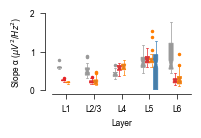

In [10]:
# cutoff at 100 Hz (frequency band spans 2 order of magnitudes)
FIG_SIZE = (1.8, 1)

# layer 1
# neuropixels
df1 = get_slope_df(dd1["alphas_spiking_nv"], "MS", "L1")
df2 = get_slope_df(dd1["alphas_spiking_ns"], "NS", "L1")
df3 = get_slope_df(dd1["alphas_spiking_ne"], "NE", "L1")

# layer 2/3
df4 = get_slope_df(dd23["alphas_spiking_nv"], "MS", "L2/3")
df5 = get_slope_df(dd23["alphas_spiking_ns"], "NS", "L2/3")
df6 = get_slope_df(dd23["alphas_spiking_ne"], "NE", "L2/3")

# layer 4
df7 = get_slope_df(dd4["alphas_spiking_nv"], "MS", "L4")
df8 = get_slope_df(dd4["alphas_spiking_ns"], "NS", "L4")
df9 = get_slope_df(dd4["alphas_spiking_ne"], "NE", "L4")

# layer 5
df10 = get_slope_df(dd5["alphas_spiking_nv"], "MS", "L5")
df11 = get_slope_df(dd5["alphas_spiking_ns"], "NS", "L5")
df12 = get_slope_df(dd5["alphas_spiking_ne"], "NE", "L5")
df13 = get_slope_df(dd5["alphas_spiking_nb"], "NB", "L5")

# layer 6
df14 = get_slope_df(dd6["alphas_spiking_nv"], "MS", "L6")
df15 = get_slope_df(dd6["alphas_spiking_ns"], "NS", "L6")
df16 = get_slope_df(dd6["alphas_spiking_ne"], "NE", "L6")

plot_df_npx = pd.concat(
    [
        df1,
        df2,
        df3,
        df4,
        df5,
        df6,
        df7,
        df8,
        df9,
        df10,
        df11,
        df12,
        df13,
        df14,
        df15,
        df16,
    ]
)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot spiking band scaling
ax = sns.boxplot(
    ax=ax,
    data=plot_df_npx,
    x="Layer",
    y="Alpha",
    hue="Experiment",
    notch=True,
    hue_order=[
        "MS",
        "NS",
        "NE",
        "NB",
    ],
    palette=[
        cl["COLOR_NV"],
        cl["COLOR_NS"],
        cl["COLOR_NE"],
        cl["COLOR_NB"],
    ],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylabel("Slope \u03B1 ($\u03bcV^2 /Hz^2$)")
ax.set_ylim([0, 2])
ax.set_yticks([0, 1, 2],[0, 1, 2])

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])
                ax.lines[k].set_mfc(cl["COLOR_NS"])
                ax.lines[k].set_mec(cl["COLOR_NS"])
            p += 1
        elif p in [10, 11, 12, 13, 14]:
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1
        elif p in [15]:
            box.set_edgecolor(cl["COLOR_NB"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NB"])
                ax.lines[k].set_mfc(cl["COLOR_NB"])
                ax.lines[k].set_mec(cl["COLOR_NB"])
            p += 1

# save
if SAVE_FIG: plt.savefig("figures/0_validation/4_power/fig2T/fig2T_fscaling_spiking_npx.svg", **savefig_cfg)

### Save TEMP data

In [ ]:
# # save plot and statistics data
# if SAVE_TEMP_DATA:
#     plot_df_npx.to_parquet(PLOT_DATA_PATH_NPX)
#     print("Saved here:", PLOT_DATA_PATH_NPX)
# elif LOAD_TEMP_DATA:
#     plot_df_npx = pd.read_parquet(PLOT_DATA_PATH_NPX)

### Hypothesis testing

In [11]:
def get_slope(df, exp, layer):
    return df[(df.Experiment == exp) & (df.Layer == layer)]["Alpha"].values


def get_kk(df, exp):
    """kruskall wallis test"""
    h, p = kruskal(
        get_slope(df, exp, "L1"),
        get_slope(df, exp, "L2/3"),
        get_slope(df, exp, "L4"),
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    )

    print(f"H={h}, p={p}")
    print(f"""N_L1 = {len(get_slope(df, exp, "L1"))} sites""")
    print(f"""N_L23 = {len(get_slope(df, exp, "L2/3"))} sites""")
    print(f"""N_L4 = {len(get_slope(df, exp, "L4"))} sites""")
    print(f"""N_L5 = {len(get_slope(df, exp, "L5"))} sites""")
    print(f"""N_L6 = {len(get_slope(df, exp, "L6"))} sites""")


def get_posthoc_dunn_holm_sidak(df, exp):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        df (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_slope(df, exp, "L1"),
        get_slope(df, exp, "L2/3"),
        get_slope(df, exp, "L4"),
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["L1", "L2/3", "L4", "L5", "L6"]
    df.index = ["L1", "L2/3", "L4", "L5", "L6"]
    return df


def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.Experiment==exp) & (plot_data.Layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record

### Slope changes across layers?

NPX

In [16]:
print("\n--------------------MS--------------------\n")
get_kk(plot_df_npx, "MS")
display(get_posthoc_dunn_holm_sidak(plot_df_npx, "MS"))
# m_m = get_medians_and_ci95(plot_df_npx, "MS", "Alpha")

print("\n--------------------NS--------------------\n")
get_kk(plot_df_npx, "NS")
get_posthoc_dunn_holm_sidak(plot_df_npx, "NS")
m_ns = get_medians_and_ci95(plot_df_npx, "NS", "Alpha")

print("\n--------------------E--------------------\n")
get_kk(plot_df_npx, "NE")
get_posthoc_dunn_holm_sidak(plot_df_npx, "NE")
m_e = get_medians_and_ci95(plot_df_npx, "NE", "Alpha")

print("\n--------------------S--------------------\n")
m_s = get_medians_and_ci95(plot_df_npx, "NB", "Alpha")


--------------------MS--------------------

H=95.83944640972834, p=7.554620083538466e-20
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites


,L1,L2/3,L4,L5,L6
L1,1.000000,1.490625e-01,3.650575e-03,5.286620e-01,4.839097e-01
L2/3,0.149063,1.000000e+00,1.299357e-01,5.345910e-06,3.391966e-09
L4,0.003651,1.299357e-01,1.000000e+00,5.313126e-11,7.286471e-16
L5,0.528662,5.345910e-06,5.313126e-11,1.000000e+00,6.931311e-01
L6,0.483910,3.391966e-09,7.286471e-16,6.931311e-01,1.000000e+00



--------------------NS--------------------

H=145.66218830918103, p=1.7302027671916752e-30
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites
0.2649 $\pm$ 0.013093, 0.2134 $\pm$ 0.01323, 0.5735 $\pm$ 0.039327, 0.7789 $\pm$ 0.03337, 0.246 $\pm$ 0.018304, 

--------------------E--------------------

H=137.94804453875656, p=7.76067635993544e-29
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites
0.2075 $\pm$ 0.008862, 0.1892 $\pm$ 0.028567, 0.5989 $\pm$ 0.044724, 0.7718 $\pm$ 0.043265, 0.2775 $\pm$ 0.036748, 

--------------------S--------------------

nan $\pm$ nan, nan $\pm$ nan, nan $\pm$ nan, 0.6855 $\pm$ 0.063342, nan $\pm$ nan, 


## Are models and in vivo data the same?

In [13]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["Experiment"] == exp) & (df["Layer"] == layer)])


def get_power(df, exp, layer):
    return df[(df["Experiment"] == exp) & (df["Layer"] == layer)]["Alpha"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_power(df, "MS", layer),
        get_power(df, "NS", layer),
        get_power(df, "NE", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_NS = {count_sites(df, "NS", layer)} sites""")
    print(f"""N_E = {count_sites(df, "NE", layer)} sites""")
    print(f"""N_M = {count_sites(df, "MS", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "MS", layer),
        get_power(plot_data, "NS", layer),
        get_power(plot_data, "NE", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["MS", "NS", "NE"]
    df.index = ["MS", "NS", "NE"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "MS", layer),
        get_power(plot_data, "NS", layer),
        get_power(plot_data, "NE", layer),
        get_power(plot_data, "NB", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["MS", "NS", "NE", "NB"]
    df.index = ["MS", "NS", "NE", "NB"]
    return df

NPX

In [14]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_df_npx, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_df_npx, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_df_npx, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_df_npx, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_df_npx, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_df_npx, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L6"))

------LAYER 1:------

H=34.28571428571428, p=3.5888205147570596e-08
N_NS = 16 sites
N_E = 16 sites
N_M = 10 sites


,MS,NS,NE
MS,1.000000e+00,0.006336,2.478699e-08
NS,6.336309e-03,1.000000,1.086724e-03
NE,2.478699e-08,0.001087,1.000000e+00



------LAYER 2/3:------

H=79.04078873357082, p=6.862949510336353e-18
N_NS = 47 sites
N_E = 47 sites
N_M = 42 sites


,MS,NS,NE
MS,1.000000e+00,1.420179e-12,4.933036e-16
NS,1.420179e-12,1.000000e+00,2.716041e-01
NE,4.933036e-16,2.716041e-01,1.000000e+00



------LAYER 4:------

H=33.42862999561757, p=5.5089042965716806e-08
N_NS = 19 sites
N_E = 19 sites
N_M = 34 sites


,MS,NS,NE
MS,1.000000e+00,0.000028,9.256764e-07
NS,2.778966e-05,1.000000,4.951700e-01
NE,9.256764e-07,0.495170,1.000000e+00



------LAYER 5:------

H=6.127923516237729, p=0.046702304990881564
N_NS = 52 sites
N_E = 52 sites
N_M = 42 sites


,MS,NS,NE,NB
MS,1.000000,0.629154,0.691516,0.691516
NS,0.629154,1.000000,0.798055,0.066543
NE,0.691516,0.798055,1.000000,0.129158
NB,0.691516,0.066543,0.129158,1.000000



------LAYER 6:------

H=161.85253721783317, p=7.147729393078138e-36
N_NS = 68 sites
N_E = 68 sites
N_M = 98 sites


,MS,NS,NE
MS,1.000000e+00,2.225073e-28,5.983232e-24
NS,2.225073e-28,1.000000e+00,3.637538e-01
NE,5.983232e-24,3.637538e-01,1.000000e+00


## Summary statistics

In [31]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

# NEUROPIXELS  ------------------

L1_ns = pc(m_m[0], m_ns[0])
L1_e = pc(m_m[0], m_e[0])

L23_ns = pc(m_m[1], m_ns[1])
L23_e = pc(m_m[1], m_e[1])

L4_ns = pc(m_m[2], m_ns[2])
L4_e = pc(m_m[2], m_e[2])

L5_ns = pc(m_m[3], m_ns[3])
L5_e = pc(m_m[3], m_e[3])

L6_ns = pc(m_m[4], m_ns[4])
L6_e = pc(m_m[4], m_e[4])

print("Models median power are on average ", - np.round(np.median([L1_ns, L1_e, L23_ns, L23_e, L4_ns, L4_e, L5_ns, L5_e, L6_ns, L6_e]),1), "% than Marques-Smith data")

print("Models median power are on average ", - np.round(np.median([L1_ns, L1_e, L23_ns, L23_e, L6_ns, L6_e]),1), "% than Marques-Smith data across L1, L23, L6")

print("Models median power are on average ", - np.round(np.median([L4_ns, L4_e, L5_ns, L5_e]),1), "% than Marques-Smith data, across L4 and L5")

Models median power are on average  -56.3 % than Marques-Smith data
Models median power are on average  -60.7 % than Marques-Smith data across L1, L23, L6
Models median power are on average  20.1 % than Marques-Smith data, across L4 and L5


In [40]:
# slope ratio between Marques-smith and Horvath
median_slope_marques = np.median(np.array([0.59, 0.5, 0.4, 0.7, 0.7]))
median_slope_horvath = np.median(np.array([1, 1.4, 1.5, 1.5, 1.3]))

print(median_slope_horvath / median_slope_marques)

2.3728813559322033


# References

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
